In [1]:
import pandas as pd

pd.set_option('display.max_columns', 100)

df_mod = pd.read_parquet('../../../data/model_data/model_data_single_output.parquet')

df_mod = df_mod.loc[df_mod['Position'] == 'DST', :].reset_index(drop=True)

df_mod

,Season,Week,Name,Position,Team,Fantasy Points,Rank,Position Rank,Adjusted Passing Yards Projection,Adjusted Passing Touchdowns Projection,Adjusted Interceptions Projection,Adjusted Rushing Yards Projection,Adjusted Receiving Yards Projection,Adjusted Receptions Projection,Anytime Touchdown Probability,Location,Team Projected Score,Opponent Projected Score
0,2020,1,Buffalo Bills,DST,BUF,8.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,23.75,17.25
1,2020,1,Pittsburgh Steelers,DST,PIT,8.0,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,25.00,19.00
2,2020,1,Baltimore Ravens,DST,BAL,15.0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,27.25,20.25
3,2020,1,New England Patriots,DST,NE,11.0,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,24.50,17.00
4,2020,1,Philadelphia Eagles,DST,PHI,3.0,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,22.00,16.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2023,17,Cincinnati Bengals,DST,CIN,4.0,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,19.50,26.50
2012,2023,17,Detroit Lions,DST,DET,6.0,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,24.50,29.00
2013,2023,17,New York Giants,DST,NYG,16.0,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.75,24.75
2014,2023,17,Arizona Cardinals,DST,ARI,2.0,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,17.75,30.25


In [2]:
X = df_mod[[
    'Position Rank',
    'Location',
    'Team Projected Score',
    'Opponent Projected Score',
]].copy()

X

,Position Rank,Location,Team Projected Score,Opponent Projected Score
0,1,1.0,23.75,17.25
1,2,-1.0,25.00,19.00
2,3,1.0,27.25,20.25
3,4,1.0,24.50,17.00
4,5,-1.0,22.00,16.50
...,...,...,...,...
2011,28,-1.0,19.50,26.50
2012,29,-1.0,24.50,29.00
2013,30,1.0,18.75,24.75
2014,31,-1.0,17.75,30.25


In [3]:
y = df_mod['Fantasy Points'].copy()

y

0        8.0
1        8.0
2       15.0
3       11.0
4        3.0
        ... 
2011     4.0
2012     6.0
2013    16.0
2014     2.0
2015     1.0
Name: Fantasy Points, Length: 2016, dtype: float64

In [4]:
groups = df_mod['Season'].astype(str) + ' Week ' + df_mod['Week'].astype(str)

groups

0        2020 Week 1
1        2020 Week 1
2        2020 Week 1
3        2020 Week 1
4        2020 Week 1
            ...     
2011    2023 Week 17
2012    2023 Week 17
2013    2023 Week 17
2014    2023 Week 17
2015    2023 Week 17
Length: 2016, dtype: object

In [5]:
df_folds = pd.read_parquet('../../../data/model_data/folds.parquet')

df_folds

,Fold ID,Season Week
0,0,2022 Week 3
1,0,2021 Week 7
2,0,2021 Week 1
3,0,2023 Week 16
4,0,2021 Week 11
...,...,...
62,2,2020 Week 15
63,2,2023 Week 14
64,2,2021 Week 5
65,2,2022 Week 6


In [6]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pd.options.mode.chained_assignment = None

# splitter = GroupKFold(n_splits=3)

cv_data = []
# for is_indexes, oos_indexes in splitter.split(X=X, y=y, groups=groups):
for fold in df_folds['Fold ID'].unique():
    oos_season_week = df_folds.loc[df_folds['Fold ID'] == fold, 'Season Week']
    is_indexes = df_mod.loc[~groups.isin(oos_season_week), :].index
    oos_indexes = df_mod.loc[groups.isin(oos_season_week), :].index
    # split
    X_is = X.iloc[is_indexes]
    X_oos = X.iloc[oos_indexes]

    y_is = y.iloc[is_indexes]
    y_oos = y.iloc[oos_indexes]

    groups_is = groups.iloc[is_indexes]
    df_mod_oos = df_mod.iloc[oos_indexes]

    gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=22)
    for train_indexes, val_indexes in gss.split(X=X_is, y=y_is, groups=groups_is):
            X_train = X_is.iloc[train_indexes]
            X_val = X_is.iloc[val_indexes]

            y_train = y_is.iloc[train_indexes]
            y_val = y_is.iloc[val_indexes]

    # impute
    scaler = StandardScaler()
    imputer = IterativeImputer(initial_strategy='median', max_iter=100)

    X_train_fill_na = imputer.fit_transform(scaler.fit_transform(X_train))
    X_train[X_train.columns] = scaler.inverse_transform(X_train_fill_na).copy()

    scaler2 = MinMaxScaler(clip=True)  # maybe normalize and clip instead of standardize?
    scaler3 = StandardScaler()
    X_train[X_train.columns] = scaler3.fit_transform(scaler2.fit_transform(X_train)).copy()

    X_val_fill_na = imputer.transform(scaler.transform(X_val))
    X_val[X_val.columns] = scaler.inverse_transform(X_val_fill_na).copy()

    X_val[X_val.columns] = scaler3.transform(scaler2.transform(X_val)).copy()

    X_oos_fill_na = imputer.transform(scaler.transform(X_oos))
    X_oos[X_oos.columns] = scaler.inverse_transform(X_oos_fill_na).copy()

    X_oos[X_oos.columns] = scaler3.transform(scaler2.transform(X_oos)).copy()

    cv_data.append((X_train, X_val, X_oos, y_train, y_val, y_oos, df_mod_oos))

for X_train, X_val, X_oos, y_train, y_val, y_oos, df_mod_oos in cv_data:
    print(X_train.shape, X_val.shape, X_oos.shape, y_train.shape, y_val.shape, y_oos.shape, df_mod_oos.shape)

(1106, 4) (216, 4) (694, 4) (1106,) (216,) (694,) (694, 18)
(1156, 4) (212, 4) (648, 4) (1156,) (212,) (648,) (648, 18)
(1138, 4) (204, 4) (674, 4) (1138,) (204,) (674,) (674, 18)


In [7]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.config.experimental import enable_op_determinism
from tensorflow.random import set_seed
import numpy as np
import os

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

def build_and_compile_model(input_shape: tuple, hidden_layer_neurons: list, l1s: list, l2s: list, learning_rate: float):
    enable_op_determinism()
    set_seed(22)
    
    inputs = Input(shape=input_shape, name='input')

    h = inputs
    for i, neurons in enumerate(hidden_layer_neurons):
        h = Dense(
            neurons, 
            activation='relu', 
            kernel_initializer=GlorotNormal(seed=22), 
            kernel_regularizer=L1L2(l1=l1s[i], l2=l2s[i]), 
            name=f"hidden_{i+1}"
        )(h)

    outputs = Dense(1, activation=None, kernel_initializer=GlorotNormal(seed=22), name='outputs')(h)

    mod = Model(inputs=inputs, outputs=outputs)

    mod.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_absolute_error'])

    return mod

mod = build_and_compile_model(X.shape[1:], [128, 32], [0, 0.01], [0, 0.01], learning_rate=0.001)

mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 hidden_1 (Dense)            (None, 128)               640       
                                                                 
 hidden_2 (Dense)            (None, 32)                4128      
                                                                 
 outputs (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [8]:
from sklearn.metrics import root_mean_squared_error
import optuna

def objective(trial, cv_data=cv_data):
# model tuning
    n_hidden_layers = trial.suggest_int(f"n_hidden_layers", 1, 3)

    hidden_layer_neurons = []
    l1s = []
    l2s = []
    for i in range(n_hidden_layers):
        hidden_layer_neurons.append(trial.suggest_categorical(f"hidden_layer_{i+1}_neurons", [2**n for n in range(5, 12)]))  # change to (3, 12)
        # hidden_layer_neurons.append(trial.suggest_categorical(f"hidden_layer_{i+1}_neurons", [2**n for n in range(4, 9)]))  # bump this up
        l1s.append(trial.suggest_float(f"hidden_layer_{i+1}_l1", 0.0, 0.1))  # change to (0.0, 0.05)
        l2s.append(trial.suggest_float(f"hidden_layer_{i+1}_l2", 0.0, 0.1))  # change to (0.0, 0.20)

    learning_rate = trial.suggest_float(f"learning_rate", 0.01, 0.10)
    batch_size = trial.suggest_categorical(f"batch_size", [2**n for n in range(10, 16)])
    # batch_size = trial.suggest_categorical(f"batch_size", [2**n for n in range(4, 12)])  # bump this up

    # cross validation
    y_oos_list = []
    y_pred_list = []
    for X_train, X_val, X_oos, y_train, y_val, y_oos, df_mod_oos in cv_data:
        # make sure to build mod in loop to prevent history
        mod = build_and_compile_model(X_train.shape[1:], hidden_layer_neurons, l1s, l2s, learning_rate)

        mod.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=500,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0,
        )

        y_oos_list.append(y_oos)
        y_pred_list.append(mod.predict(X_oos, verbose=0))

    y_oos_concat = np.concatenate(y_oos_list)
    y_pred_concat = np.concatenate(y_pred_list)

    return root_mean_squared_error(y_oos_concat, y_pred_concat)

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=22, n_startup_trials=10, multivariate=True, warn_independent_sampling=False))
study.optimize(objective, n_trials=20, show_progress_bar=True)

study.best_params

c:\Users\mhugh\anaconda3\envs\clean2\lib\site-packages\optuna\_experimental.py:30: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-10-23 16:59:18,439] A new study created in memory with name: no-name-439e97e8-9e59-4f41-b0f0-67d5b3b03dab


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-10-23 16:59:34,814] Trial 0 finished with value: 5.772438565884545 and parameters: {'n_hidden_layers': 1, 'hidden_layer_1_neurons': 128, 'hidden_layer_1_l1': 0.022040451663772567, 'hidden_layer_1_l2': 0.08119509205386867, 'learning_rate': 0.01094741868844976, 'batch_size': 2048}. Best is trial 0 with value: 5.772438565884545.
[I 2024-10-23 16:59:40,754] Trial 1 finished with value: 7.968439465899037 and parameters: {'n_hidden_layers': 3, 'hidden_layer_1_neurons': 128, 'hidden_layer_1_l1': 0.058428964315689495, 'hidden_layer_1_l2': 0.07026355188654519, 'hidden_layer_2_neurons': 128, 'hidden_layer_2_l1': 0.08749277452777171, 'hidden_layer_2_l2': 0.07449320773686179, 'hidden_layer_3_neurons': 256, 'hidden_layer_3_l1': 0.009588460991804116, 'hidden_layer_3_l2': 0.004521011190769353, 'learning_rate': 0.07163458468004151, 'batch_size': 1024}. Best is trial 0 with value: 5.772438565884545.
[I 2024-10-23 16:59:46,658] Trial 2 finished with value: 6.131271090024767 and parameters: {'n_h

{'n_hidden_layers': 2,
 'hidden_layer_1_neurons': 256,
 'hidden_layer_1_l1': 0.016031351072220416,
 'hidden_layer_1_l2': 0.07542542291704282,
 'hidden_layer_2_neurons': 64,
 'hidden_layer_2_l1': 0.09865311357332089,
 'hidden_layer_2_l2': 0.05806487655603816,
 'learning_rate': 0.03800967715506095,
 'batch_size': 1024}

5.604530867792031

In [9]:
n_hidden_layers = study.best_params['n_hidden_layers']

hidden_layer_neurons = []
l1s = []
l2s = []
for i in range(n_hidden_layers):
    hidden_layer_neurons.append(study.best_params[f"hidden_layer_{i+1}_neurons"])
    l1s.append(study.best_params[f"hidden_layer_{i+1}_l1"])
    l2s.append(study.best_params[f"hidden_layer_{i+1}_l2"])

learning_rate = study.best_params[f"learning_rate"]
batch_size = study.best_params[f"batch_size"]

y_oos_list = []
y_pred_list = []
testing_data = []
for X_train, X_val, X_oos, y_train, y_val, y_oos, df_mod_oos in cv_data:
    # make sure to build mod in loop to prevent history
    mod = build_and_compile_model(X_train.shape[1:], hidden_layer_neurons, l1s, l2s, learning_rate)

    mod.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=500,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1,
    )

    y_preds = mod.predict(X_oos, verbose=0)

    df_preds = pd.DataFrame(
        y_preds,
        columns=['Prediction']
    )

    testing_data.append(pd.concat((df_mod_oos.reset_index(drop=True), df_preds), axis=1))


    y_oos_list.append(y_oos)
    y_pred_list.append(y_preds)

df_test = pd.concat(testing_data, ignore_index=True)

y_oos_concat = np.concatenate(y_oos_list)
y_pred_concat = np.concatenate(y_pred_list)

print(f"OOS RMSE: {root_mean_squared_error(y_oos_concat, y_pred_concat)}")

Epoch 1/500
2/2 [==============================] - 1s 323ms/step - loss: 188.6583 - mean_absolute_error: 6.8804 - val_loss: 88.0716 - val_mean_absolute_error: 3.8649
Epoch 2/500
2/2 [==============================] - 0s 48ms/step - loss: 96.1160 - mean_absolute_error: 4.4842 - val_loss: 79.2096 - val_mean_absolute_error: 4.1049
Epoch 3/500
2/2 [==============================] - 0s 48ms/step - loss: 84.1819 - mean_absolute_error: 4.4942 - val_loss: 82.0754 - val_mean_absolute_error: 4.4240
Epoch 4/500
2/2 [==============================] - 0s 48ms/step - loss: 86.9790 - mean_absolute_error: 4.5565 - val_loss: 70.7970 - val_mean_absolute_error: 3.9411
Epoch 5/500
2/2 [==============================] - 0s 49ms/step - loss: 75.5590 - mean_absolute_error: 4.2558 - val_loss: 64.4644 - val_mean_absolute_error: 4.1063
Epoch 6/500
2/2 [==============================] - 0s 50ms/step - loss: 69.1196 - mean_absolute_error: 4.4908 - val_loss: 60.0323 - val_mean_absolute_error: 4.1822
Epoch 7/500
2/

In [10]:
df_test['Prediction'].describe()

count    2016.000000
mean        6.640348
std         1.540173
min         3.908088
25%         5.371675
50%         6.492318
75%         7.814518
max        11.387899
Name: Prediction, dtype: float64

In [11]:
(df_test['Fantasy Points'] - df_test['Prediction']).describe()

count    2016.000000
mean        0.027806
std         5.605852
min       -13.061255
25%        -3.711277
50%        -1.009756
75%         3.088506
max        28.904758
dtype: float64

In [12]:
(df_test['Fantasy Points'] - df_test['Prediction']).abs().describe()

count    2016.000000
mean        4.318317
std         3.573408
min         0.001316
25%         1.719387
50%         3.450190
75%         6.031510
max        28.904758
dtype: float64

In [13]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(df_test['Fantasy Points'], df_test['Prediction'])

5.604530867792031

In [14]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_test['Fantasy Points'], df_test['Prediction'])

4.31831661446227

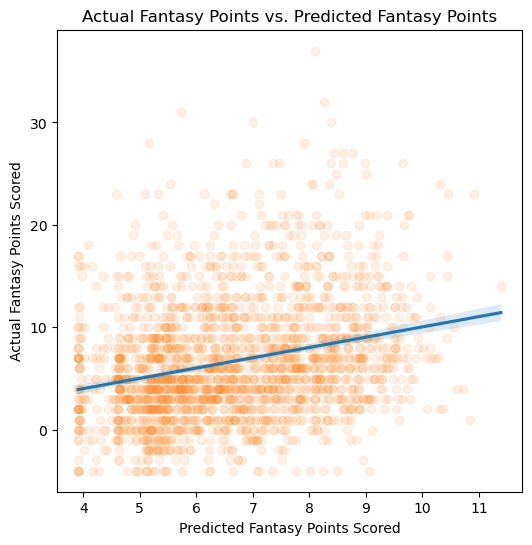

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6), dpi=100)

ax = sns.regplot(
    data=df_test,
    x='Prediction',
    y='Fantasy Points',
    scatter_kws={'alpha': 0.10, 'color': sns.color_palette()[1]},
    line_kws={'color': sns.color_palette()[0]},
)

plt.title('Actual Fantasy Points vs. Predicted Fantasy Points')
plt.xlabel('Predicted Fantasy Points Scored')
plt.ylabel('Actual Fantasy Points Scored')

plt.show()

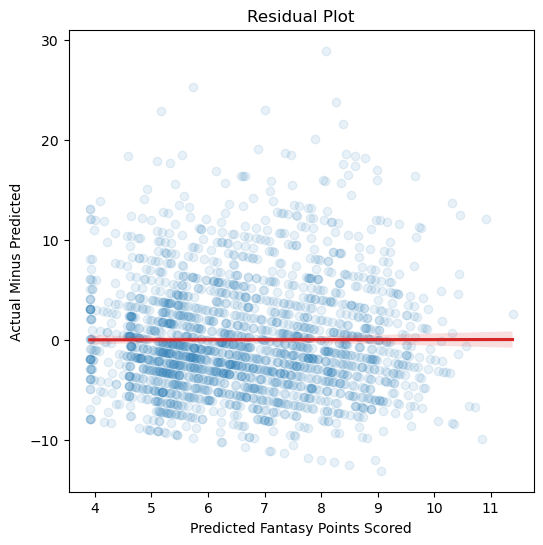

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6), dpi=100)

ax = sns.regplot(
    data=df_test.assign(f=(df_test['Fantasy Points'] - df_test['Prediction'])),
    x='Prediction',
    y='f',
    scatter_kws={'alpha': 0.10, 'color': sns.color_palette()[0]},
    line_kws={'color': sns.color_palette()[3]},
)

plt.title('Residual Plot')
plt.xlabel('Predicted Fantasy Points Scored')
plt.ylabel('Actual Minus Predicted')

plt.show()

In [17]:
import shap

explainer = shap.DeepExplainer(mod, X_train.to_numpy())

shap_values = explainer(X_train.to_numpy())

shap_values.feature_names = X_train.columns

shap_values.shape

c:\Users\mhugh\anaconda3\envs\clean2\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\mhugh\anaconda3\envs\clean2\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


(1138, 4, 1)

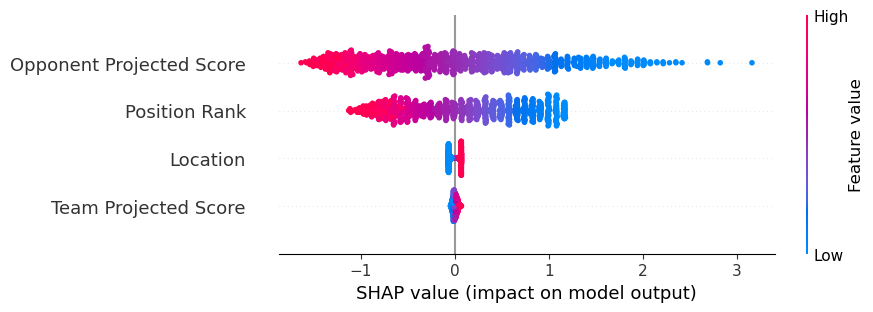

In [18]:
shap.plots.beeswarm(shap_values[:, :, 0], max_display=None)

### Save Predictions

In [20]:
df_test.to_parquet('../../../data/out_of_sample_predictions/dst.parquet')

print('Done')

Done
